# 13. 인공지능으로 세상에 없던 새로운 패션 만들기


#### 학습목표


 - 생성 모델링 개념을 이해하며 판별 모델링과의 차이 알기
 
 - Pix2Pix, CycleGAN 등의 이미지 관련 다양한 생성 모델링의 응용을 접하며 흥미 가지기

 - Fashion MNIST 데이터셋의 의미를 알기

 - 생성적 적대 신경망(GAN)의 구조와 원리를 이해하기

 - 텐서플로우로 짠 DCGAN 학습 코드를 익히며 응용하기
 
 
#### 13-2. 없던 데이터를 만들어낸다, 생성 모델링

판별 모델 : 입력된 데이터셋을 특정 기준에 따라 분류하거나, 특정 값을 맞추는 모델


생성 모델 : 학습한 데이터셋과 비슷하면서도 기존에는 없던 새로운 데이터셋을 생성하는 모델로 정리할 수 있습니다.

`할 수 있는 일'

1) 생성 모델로 다른 판별 모델을 학습시키는 데에 필요한 데이터를 만들어낸다.

2) 베토벤의 음악을 학습한 후, 그와 비슷한 분위기의 새로운 음악을 만들어낸다.

3) 글을 생성하는 방법을 학습한 모델로 기사 또는 소설 등을 창작해낸다.

4) 여러 사람의 얼굴을 학습해서 세상에 없는 사람 얼굴을 만들어낸다.


#### 13-3. 여러 가지 생성 모델링 기법과 친해지기 (1) Pix2Pix

그림을 사진으로 변환해 보자: Pix2Pix


Pix2Pix는 간단한 이미지를 입력할 경우 실제 사진처럼 보이도록 바꿔줄 때 많이 사용되는 모델입니다.

모델은 아래 그림처럼 단순화된 이미지(Input Image) 와 실제 이미지(Ground Truth) 가 쌍을 이루는 데이터셋으로 학습을 진행합니다.


왼쪽의 Input Image를 입력받으면, 내부 연산을 통해 실제 사진 같은 형상으로 변환된 Predicted Image를 출력하는 거죠. 학습 초기에는 모델이 생성한 Predicted Image가 Ground Truth 이미지와 많이 다르겠지만, 계속해서 Ground Truth와 얼마나 비슷한지를 평가하며 점차 실제 같은 결과물을 만들어 내게 됩니다. 이렇게 한 이미지를 다른 이미지로 픽셀 단위로 변환한다는 뜻의 Pixel to Pixel을 딴 Pix2Pix로 이름이 붙게 되었습니다.

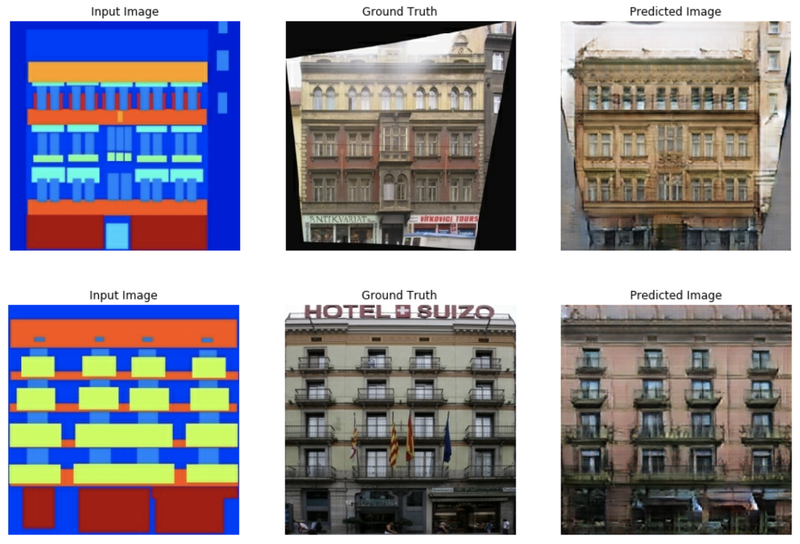

#### 1.1 필요한 라이브러리 로드

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

from IPython import display
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.1


In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170500096/170498071 [==============================] - 12s 0us/step


(50000, 32, 32, 3)

#### 1.2 데이터셋 확인

 - CIFAR10은 열 가지 클래스의 이미지를 모아둔 데이터 셋이다.
 - 이미지의 크기는 (32,32,3)이다.

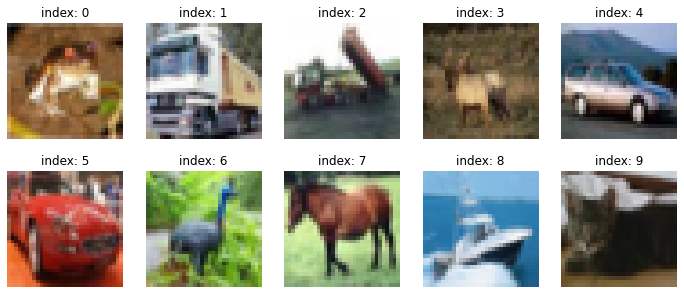

In [8]:
plt.figure(figsize=(12,5)) # 프레임 크기 결정

for i in range(10):
    plt.subplot(2, 5, i+1) # 여러 이미지 띄우기
    plt.imshow(train_x[i].reshape(32, 32,3))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

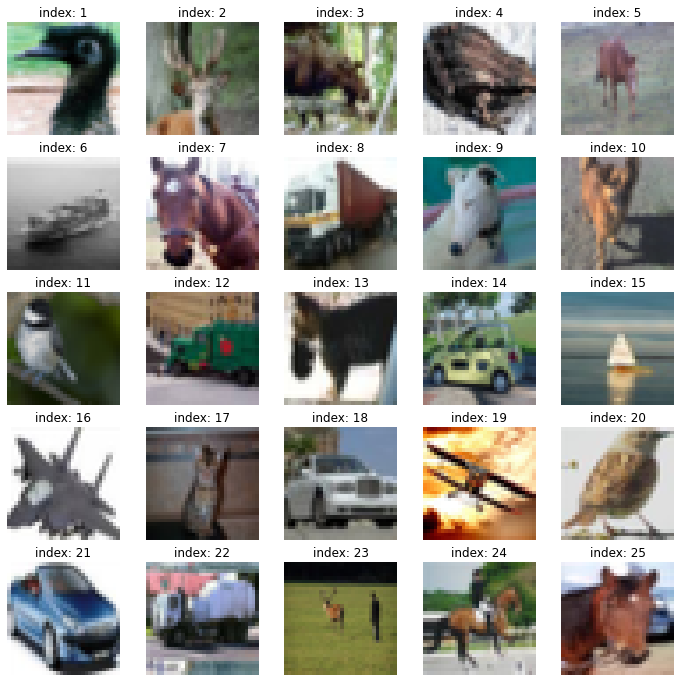

In [10]:
plt.figure(figsize=(12, 12))

for i in range(1,26):
    idx = np.random.randint(0, len(train_x)-1)
    plt.subplot(5,5, i)
    plt.imshow(train_x[idx].reshape(32, 32,3))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

#### 1.3 학습데이터 정규화

학습에 사용할 이미지는 [-1, 1] 값으로 정규화를한다.

In [11]:
train_x = (train_x - 127.5) / 127.5

In [12]:
# 미니배치 생성

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train_dataset

<BatchDataset shapes: (None, 32, 32, 3), types: tf.float64>

## 2 GAN 모델 생성

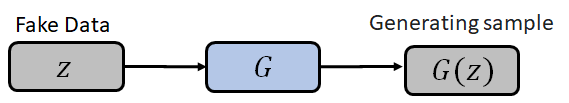

### 2.1 생성자 모델

In [43]:
# 기존 모델
def make_generator_model_base():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [25]:
# # Dense 입력 사이즈와 LeakyReLU alpha=0.2
# # 커널 사이즈 5로 스트라이드 2로





def make_generator_model(alpha=0.2):

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4*4*64*8, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 512)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(512, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1024, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    # model.output_shape == (BACHE_SIZE, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha)) 

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [44]:
generator_base = make_generator_model_base()
generator_base.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_14 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_15 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 8, 8, 128)        

In [26]:
generator = make_generator_model()
generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8192)              819200    
_________________________________________________________________
batch_normalization_10 (Batc (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 4, 4, 512)         6553600   
_________________________________________________________________
batch_normalization_11 (Batc (None, 4, 4, 512)         2048      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 4, 4, 512)        

In [27]:
# create image by using generator model
noise = tf.random.normal([1, 100])

generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

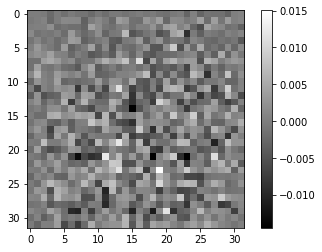

In [28]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

## 3.2 판별자 모델


판별자 모델은 (32, 32, 3)의 이미지를 입력으로 받아 1차원으로 판별 결과를 출력한다.
앞서 생성한 랜덤 이미지를 입력으로 넣을 때 수치를 출력하는지 확인해보자.

real이미지와 false이미지를 구분한다!

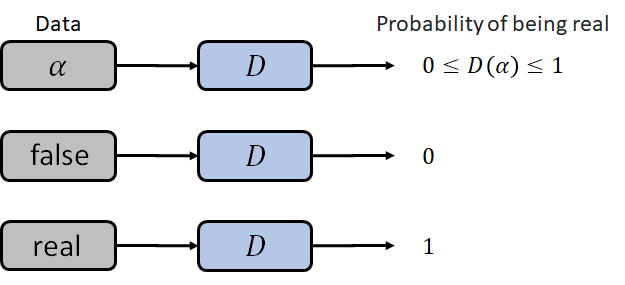

In [46]:
# 기본 모델 
def make_discriminator_model_base():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [47]:
def make_discriminator_model(alpha=0.2):

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(0.3))
    
    # Third: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(0.3))
    
   # Third: Conv2D Layer
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(0.3))
    
    # Third: Flatten Layer
    model.add(layers.Flatten())
    
    model.add(layers.Dropout(0.4))
    
    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [48]:
discriminator_base = make_discriminator_model_base()

discriminator_base.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)             

In [49]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 16, 16, 64)        1792      
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 128)        

In [51]:
decision_base = discriminator_base(generated_image, training=False)
decision_base

decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00030809]], dtype=float32)>

#### 3.1 모델 동작

모델 동작의 예시는 아래와 같다.

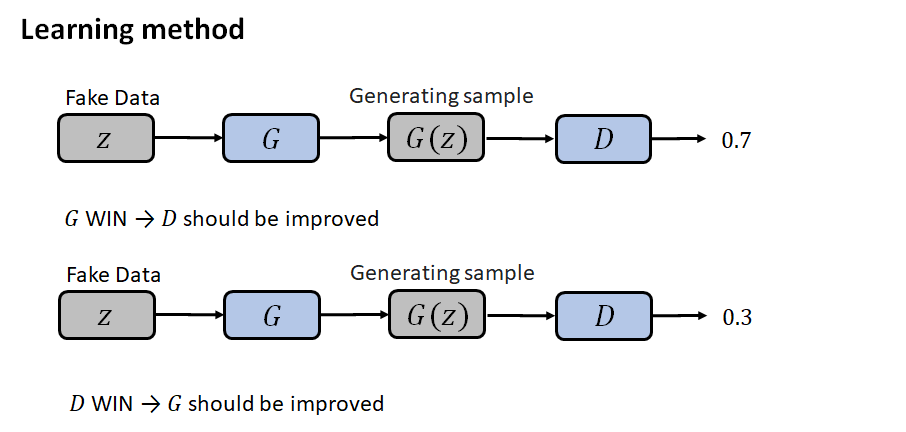

## 4. 손실함수와 옵티마이저 정의

### 4.1 손실함수 (loss function)
GAN은 생성자와 판별자 즉 2명의 플레이어의 Zero-sum Game이다. loss 식은 아래와 같다.


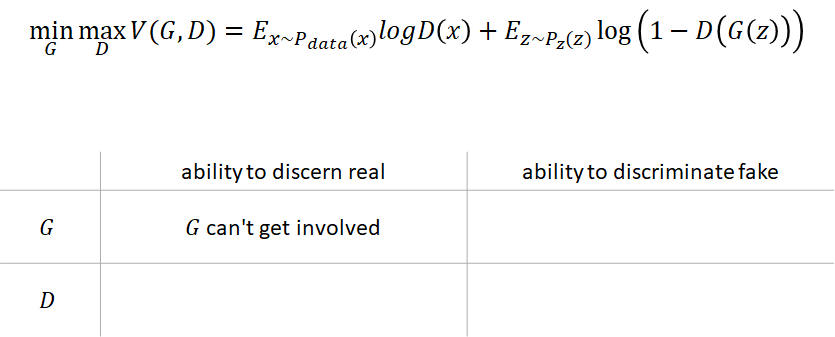


 - 생성자, 판별자의 손실함수 및 accuracy 지표 구현한다.


 - GAN은 손실함수로 Crossentropy를 사용한다.



In [33]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


 - **def discriminator_accuracy(real_output, fake_output)** : 생성자가 이미지를 잘 만들어내면 판별자는 이미지가 진실인지 거짓인지를 판단하기 어려워 확률에 의존하게 된다. 즉, accuracy는 0.5에 수렴할 수록 생성자가 제대로 학습한 것이다.

In [34]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

 - **def generator_loss(fake_output)** : Crossentropy 를 사용해 생성한 이미지가 판별자를 얼마나 잘 속였는지 파악. -> 작을 수록 좋다.

In [35]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss



 - **def discriminator_loss(real_output, fake_output)** : 판별자가 진실과 거짓을 얼마나 잘 판별했는지 두개의 Crossentropy의 합으로 가늠. -> 작을 수록 좋다.


In [36]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

## 4.2 최적화 함수 (optimizer)

생성자와 판별자는 따로 훈련되기 때문에, 판별자와 생성자의 옵티마이저는 다르다.

In [37]:
generator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

In [38]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## 5. 훈련과정 설계

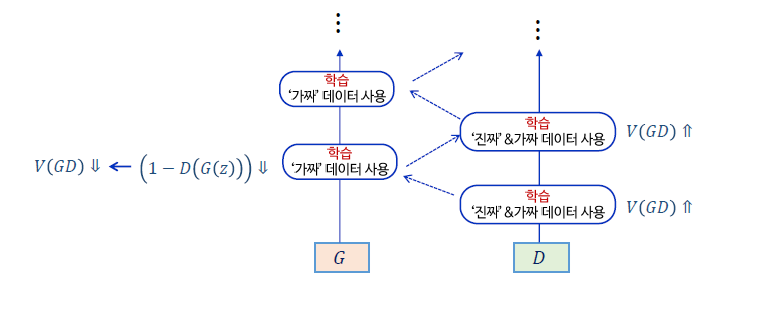


 - def train_step(images, gen, dis) : 미니배치 한 개 훈련 과정
 
 - 생성자는 노이즈로부터 이미지를 생성해내어서 판별자에게 전달한다.

 - 실제 원본 이미지도 판별자에게 전달한다.

 - 두 출력 값을 통해 loss와 accuracy를 계산하고 gradient를 계산한다.

In [63]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

### 5-2. 학습 현황 확인하는 샘플 생성 함수

 - def generate_and_save_images(model, epoch, it, sample_seeds, dirno=1) : 훈련하면서 생성한 이미지를 시각화하는 함수.
 
- 1~1 사이로 정규화했던 데이터 셋을 다시 돌려놓는다.

In [56]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/EXP_13_dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

#### 5-3. 체크포인트

학습 결과를 체크포인트로 저장하자.
앞서 정의한 optimizer 설정과 생성자, 판별자 모델을 입력으로 받아 tf.train.Checkpoint 객체를 생성한다.

In [57]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/EXP_13_dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

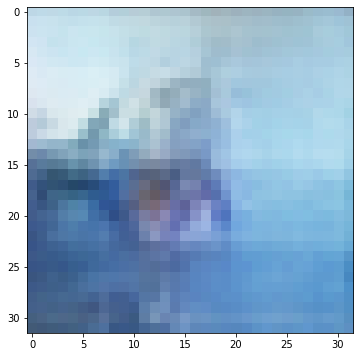

In [67]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

new_generator = checkpoint.generator
new_discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = new_generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

## 6. 모델 훈련

 - **def make_gif(dirno)** : 학습 과정 동안 생성한 이미지들로 gif 파일을 생성해 학습 진행 과정을 시각화
 
 
  - **def train(dataset, epochs, save_every, dirno, genno, disno)** : 실제 학습 진행하는 함수. save_every에 지정한 epochs 때 마다 저장한다.
학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다. 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.

In [60]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [65]:
save_every = 5
EPOCHS = 200

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

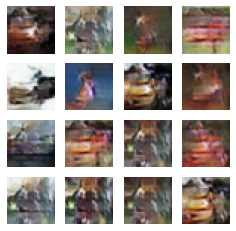

Time for training : 36874 sec


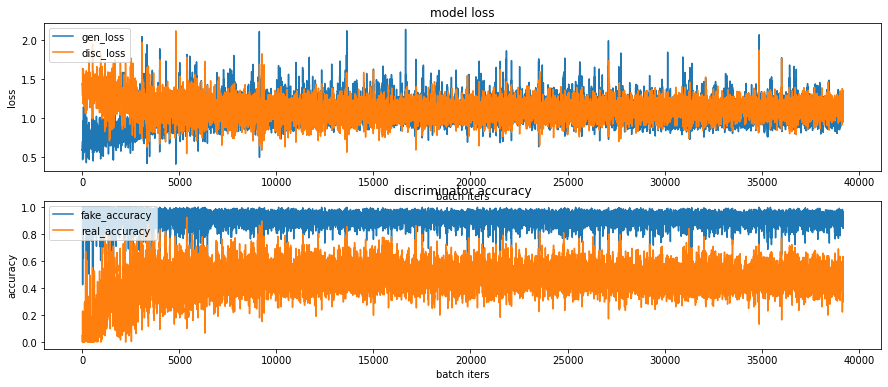

CPU times: user 7h 22min 45s, sys: 2h 50min 16s, total: 10h 13min 1s
Wall time: 10h 14min 36s


In [66]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [78]:
def make_gif(dirno):
    anim_file = os.getenv('HOME')+f'/aiffel/EXP_13_dcgan_newimage/cifar10/cifar_dcgan{dirno}.gif'

    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = glob.glob('{}/aiffel/EXP_13_dcgan_newimage/cifar10/generated_samples{:02d}/sample*.png'.format(os.getenv('HOME'), dirno))
        filenames = sorted(filenames)
        last = -1
        for i, filename in enumerate(filenames):
            frame = 2*(i**0.5)
            if round(frame) > round(last):
                last = frame
            else:
                continue
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

## step7) GAN 훈련과정 개선 (optional)

## 회고

개선된 점


 - LeakyReLU(alpha=0.2))
 - BatchNormalization(momentum = 0.9)
 - Adam(lr=0.0002, beta_1=0.5)


처음 베이스라인 모델을 돌릴 때 시간 때문에 200에폭에서 멈췄다. 개선된 모델을 봐야할 시간이 필요했기에 마저 돌리지 못했다. 그래서 200에폭에서 동일한 사진을 비교 해봤다.


### 아쉬운점

이미지 자체가 선명하지 못하게 나왔고, loss 값이 매우 크게 나왔다. 육안으로도 어떠한 물체가 이미지 내에 있는지 확인하기 어려울 정도로 성능이 낮게 나왔다.

시간이 더 있다면 성능개선 및 다양한 GAN모델 사용으로 더 나은 이미지를 만들어보고 싶다. 